<a href="https://colab.research.google.com/github/enelene/Walmart-Recruiting---Store-Sales-Forecasting/blob/main/notebooks/model_experiment_TFT_neuralforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys
# Add the directory containing your script to the Python path
sys.path.append('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main')

In [3]:
!pip install -r  drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/requirements.txt

In [4]:
print("\n--- Imports & Setup ---")
import pandas as pd
import numpy as np
import os
import warnings
import wandb
import torch
import gc
import matplotlib.pyplot as plt
import optuna

from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import MAE
from pytorch_lightning.loggers import WandbLogger


--- Imports & Setup ---


In [5]:
def wmae(y_true, y_pred, is_holiday):
    """Computes the Weighted Mean Absolute Error."""
    weights = np.where(np.array(is_holiday, dtype=bool), 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)


In [6]:
wandb.login(key = "720b5644412076fa3e35eb1ffccab9895b8369db")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: egabe21 (egabe21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
WANDB_PROJECT = "Walmart-Sales-TFT-Tuning"


In [8]:

def plot_attention(nf_model):
    """Plots the mean attention weights from a trained NeuralForecast TFT model."""
    try:
        # The attention_weights() method returns the full attention matrix.
        # We need to select the attention from the forecast period back to the history period
        # and then average it to get a single score per historical time step.
        attention_matrix = nf_model.attention_weights()
        input_size = nf_model.input_size

        # Slice the matrix to get attention from forecast steps to input steps
        forecast_to_history_attention = attention_matrix[input_size:, :input_size]

        # Average across the forecast horizon to get a single importance score for each past time step
        mean_attention = forecast_to_history_attention.mean(axis=0)

        fig, ax = plt.subplots(figsize=(10, 5))
        # The x-axis represents the time lag from the prediction point
        ax.plot(np.arange(-input_size, 0), mean_attention)
        ax.set_title("Mean Attention Weights")
        ax.set_xlabel("Time Lag (Weeks from Prediction Point)")
        ax.set_ylabel("Attention Weight")
        ax.grid(True)
        plt.show()
        return fig
    except Exception as e:
        print(f"Could not plot attention weights: {e}")
        return None

In [9]:
# --- Model Parameters ---
# The forecast horizon 'h' must match the length of our validation and test sets.
HORIZON = 39
# The input size is the lookback window for the model. 1 year is a good start.
INPUT_SIZE = 52

In [10]:
try:
    train_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/train_final.csv', parse_dates=['Date'])
    validation_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/validation_final.csv', parse_dates=['Date'])
    test_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/test_final.csv', parse_dates=['Date'])
    print("Successfully loaded all pre-split data files.")
except KeyError:
    print("ERROR: Make sure you have uploaded all three required CSV files.")
    raise

Successfully loaded all pre-split data files.


In [11]:
def prepare_for_nf(df, is_train=True):
    """Prepares a DataFrame for NeuralForecast by renaming and creating necessary columns."""
    df_copy = df.copy()
    # Create the 'unique_id' by combining Store and Dept
    df_copy['unique_id'] = df_copy['Store'].astype(str) + '_' + df_copy['Dept'].astype(str)
    # Rename 'Date' to 'ds'
    df_copy.rename(columns={'Date': 'ds'}, inplace=True)
    # If it's a dataset with a target, rename the target to 'y'
    if is_train and 'Weekly_Sales' in df_copy.columns:
        df_copy.rename(columns={'Weekly_Sales': 'y'}, inplace=True)
    return df_copy


In [12]:
nf_train_df = prepare_for_nf(train_df)
nf_validation_df = prepare_for_nf(validation_df)
y_val_true = nf_validation_df['y']
is_holiday_val = nf_validation_df['IsHoliday']

In [13]:
stat_exog_list = ['Store', 'Dept', 'Size'] + [col for col in train_df.columns if 'Type_' in col]
hist_exog_list = [col for col in train_df.columns if 'Sales_Lag' in col or 'Sales_Roll' in col or 'Weekly_Returns' in col or 'Temperature' in col or 'Fuel_Price' in col or 'Markdown' in col or 'CPI' in col or 'Unemployment' in col or 'MarkDown' in col]
futr_exog_list = [col for col in train_df.columns if col not in ['Date', 'Weekly_Sales', 'Store_Dept'] + stat_exog_list + hist_exog_list]
print(f"Found {len(stat_exog_list)} static, {len(hist_exog_list)} historic, and {len(futr_exog_list)} future features.")


Found 6 static, 20 historic, and 9 future features.


In [14]:
static_df = nf_train_df[['unique_id'] + stat_exog_list].drop_duplicates()


In [15]:
# The main training DataFrame should only contain time-varying columns.
time_varying_cols = ['unique_id', 'ds', 'y'] + hist_exog_list + futr_exog_list
nf_train_df_time_varying = nf_train_df[time_varying_cols]


In [ ]:
print(stat_exog_list), print(hist_exog_list), print(futr_exog_list)

In [17]:
print("\n--- Model Training ---")
run = wandb.init(project=WANDB_PROJECT, name="TFT-Advanced-Interpretability")



--- Model Training ---


In [18]:

gc.collect()
torch.cuda.empty_cache()

In [19]:
models = [
    TFT(
        h=HORIZON,
        input_size=INPUT_SIZE,
        stat_exog_list=stat_exog_list,
        hist_exog_list=hist_exog_list,
        futr_exog_list=futr_exog_list,
        batch_size=32,
        hidden_size=16,
        n_head=2, # Reduce number of attention heads
        max_steps=1500, # Number of training steps
        early_stop_patience_steps=15, # Stop if validation loss doesn't improve
        loss=MAE(),
        scaler_type='robust', # Helps with outliers in sales data
        random_seed=42
    )
]

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [20]:
nf = NeuralForecast(models=models, freq='W-FRI')


In [21]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [22]:
nf_train_df

,Store,Dept,ds,y,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Sales_Roll_Mean_4,Sales_Roll_Std_4,Sales_Roll_Min_4,Sales_Roll_Max_4,HasMarkdown,Store_Dept,Type_A,Type_B,Type_C,unique_id
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.00,...,32990.7700,12832.106391,19403.54,46039.49,0,1_1,1,0,0,1_1
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.00,0.00,0.00,...,32990.7700,12832.106391,19403.54,46039.49,0,1_1,1,0,0,1_1
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.00,0.00,0.00,...,32990.7700,12832.106391,19403.54,46039.49,0,1_1,1,0,0,1_1
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.00,0.00,0.00,...,32990.7700,12832.106391,19403.54,46039.49,0,1_1,1,0,0,1_1
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.00,0.00,0.00,...,32990.7700,12832.106391,19403.54,46039.49,0,1_1,1,0,0,1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305977,45,98,2011-12-30,553.21,True,37.79,3.389,3604.35,43941.56,287.45,...,762.3675,257.116069,538.51,1084.78,1,45_98,0,1,0,45_98
305978,45,98,2012-01-06,698.76,False,35.88,3.422,7328.14,33378.79,34.60,...,766.0425,252.920722,553.21,1084.78,1,45_98,0,1,0,45_98
305979,45,98,2012-01-13,677.71,False,41.18,3.513,3489.73,11219.72,0.92,...,797.5525,227.367911,553.21,1084.78,1,45_98,0,1,0,45_98
305980,45,98,2012-01-20,848.84,False,31.85,3.533,3205.90,4038.51,2.19,...,753.6150,229.929744,553.21,1084.78,1,45_98,0,1,0,45_98


In [23]:
nf.fit(df=nf_train_df_time_varying, static_df=static_df, val_size=HORIZON)
print("Training complete.")

/usr/local/lib/python3.11/dist-packages/neuralforecast/core.py:553: UserWarning: Validation set size is larger than the shorter time-series.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 1.2 K  | train
4 | static_encoder          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1500` reached.


Training complete.


In [24]:
# This ensures the future dataframe has all the required (unique_id, ds) combinations.
future_df_scaffold = nf.make_future_dataframe()
# Merge our validation features onto this scaffold to populate it.
future_df_with_features = pd.merge(future_df_scaffold, nf_validation_df, on=['unique_id', 'ds'], how='left')
# Fill any missing values that might arise from the merge
future_df_with_features.fillna(method='ffill', inplace=True)
future_df_with_features.fillna(method='bfill', inplace=True)
future_df_with_features.fillna(0, inplace=True)


/tmp/ipython-input-42619250.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_df_with_features.fillna(method='ffill', inplace=True)
/tmp/ipython-input-42619250.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future_df_with_features.fillna(method='ffill', inplace=True)
/tmp/ipython-input-42619250.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_df_with_features.fillna(method='bfill', inplace=True)


In [25]:
print("\n--- Evaluating model on the hold-out validation set ---")

# Now, predict using this complete and feature-rich future dataframe.
predictions_df = nf.predict(futr_df=future_df_with_features, static_df=static_df)
eval_df = pd.merge(nf_validation_df, predictions_df, on=['unique_id', 'ds'])

# Calculate all performance metrics
wmae_score = wmae(eval_df['y'], eval_df['TFT'], eval_df['IsHoliday'])
mae_score = np.mean(np.abs(eval_df['y'] - eval_df['TFT']))
rmse_score = np.sqrt(np.mean((eval_df['y'] - eval_df['TFT'])**2))

print(f"Validation WMAE Score: {wmae_score:.4f}")
print(f"Validation MAE Score:  {mae_score:.4f}")
print(f"Validation RMSE Score: {rmse_score:.4f}")

# Log all metrics to the current wandb run
wandb.log({
    "validation_wmae": wmae_score,
    "validation_mae": mae_score,
    "validation_rmse": rmse_score
})


--- Evaluating model on the hold-out validation set ---


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Validation WMAE Score: 2297.0851
Validation MAE Score:  2276.7578
Validation RMSE Score: 4975.0769


In [26]:
sample_eval_df = eval_df.sample(n=min(1000, len(eval_df)), random_state=42)
wandb.log({"validation_predictions_sample": wandb.Table(dataframe=sample_eval_df[['unique_id', 'ds', 'y', 'TFT', 'IsHoliday']])})


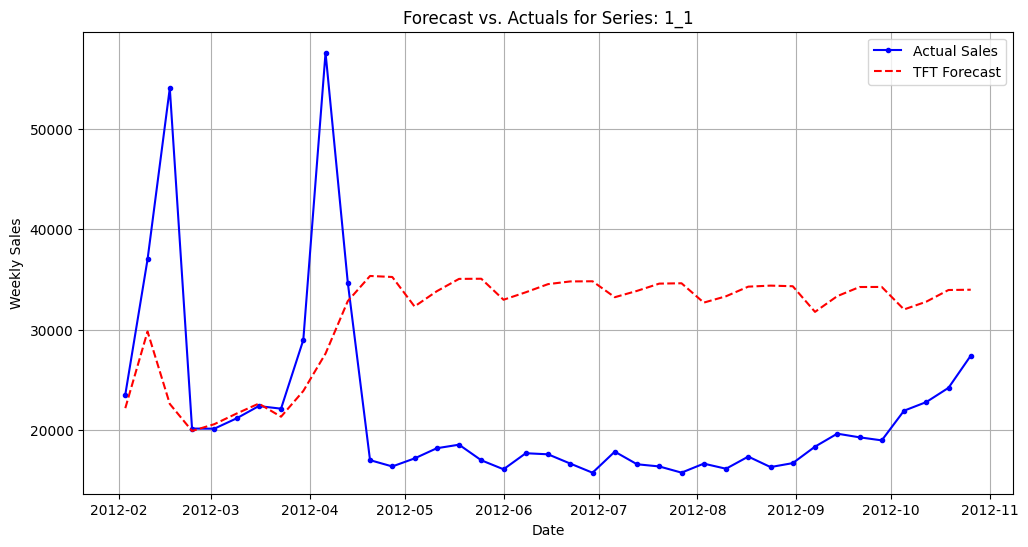

In [27]:
try:
    sample_id = eval_df['unique_id'].unique()[0]
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot actuals
    eval_sample = eval_df[eval_df['unique_id'] == sample_id]
    ax.plot(eval_sample['ds'], eval_sample['y'], label='Actual Sales', color='blue', marker='.')

    # Plot forecast
    ax.plot(eval_sample['ds'], eval_sample['TFT'], label='TFT Forecast', color='red', linestyle='--')

    ax.set_title(f'Forecast vs. Actuals for Series: {sample_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales')
    ax.legend()
    ax.grid(True)

    # Log the plot to wandb
    wandb.log({f"forecast_plot_{sample_id}": wandb.Image(fig)})
    plt.show()
except Exception as e:
    print(f"Could not generate forecast plot: {e}")




--- Generating Interpretability Plots ---
Plotting mean attention weights...


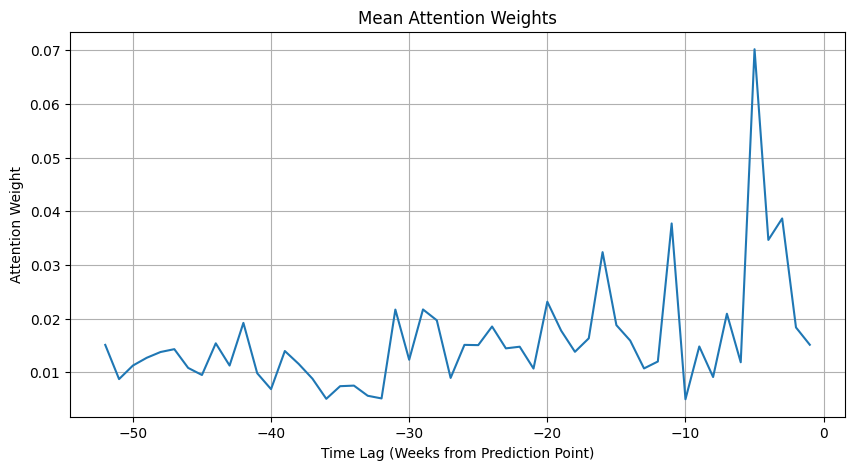

Calculating and plotting feature importances...


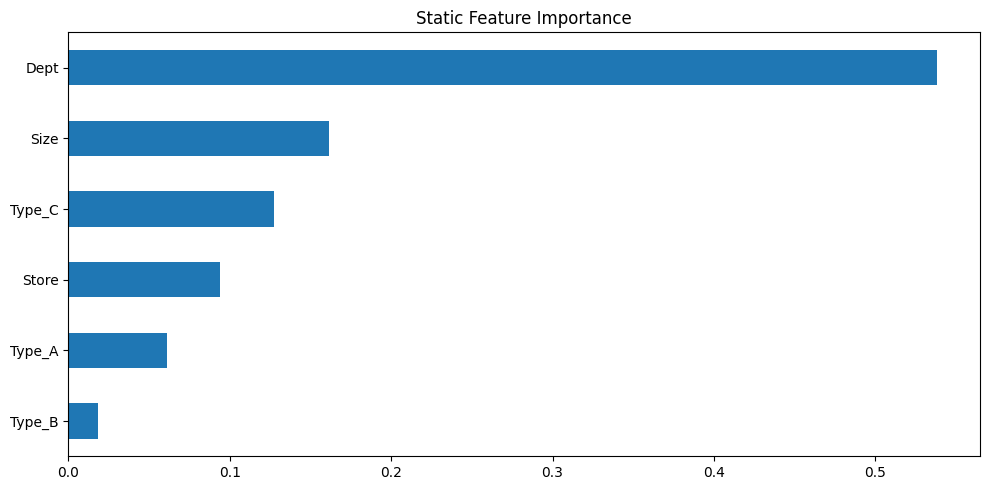

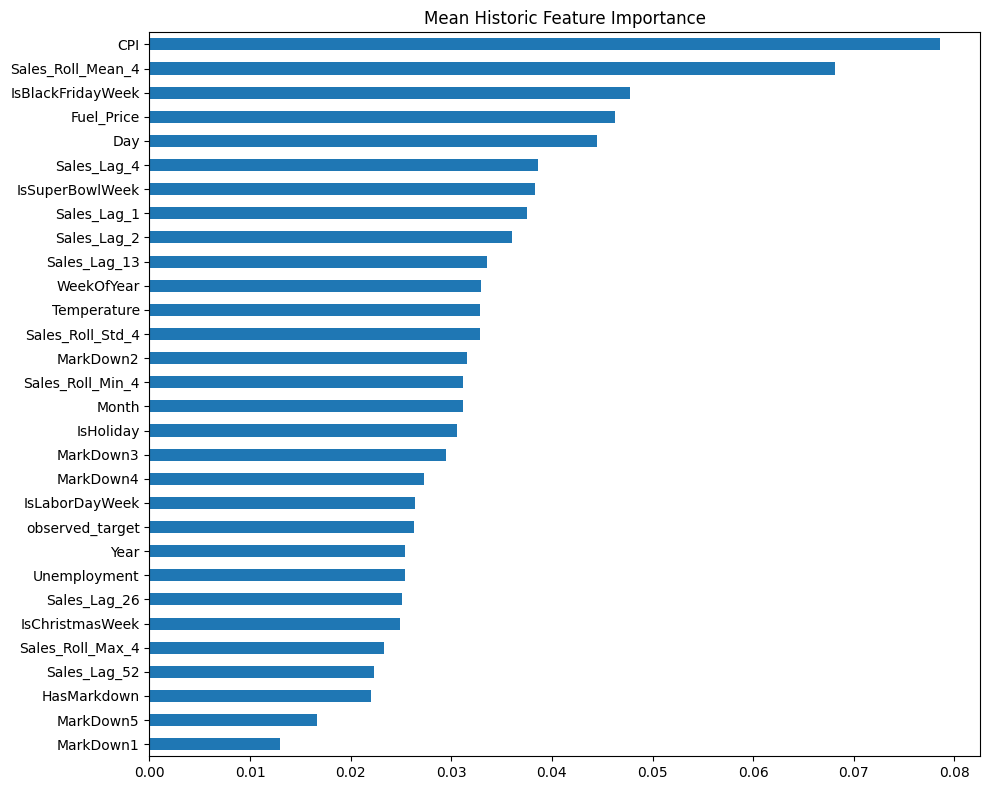

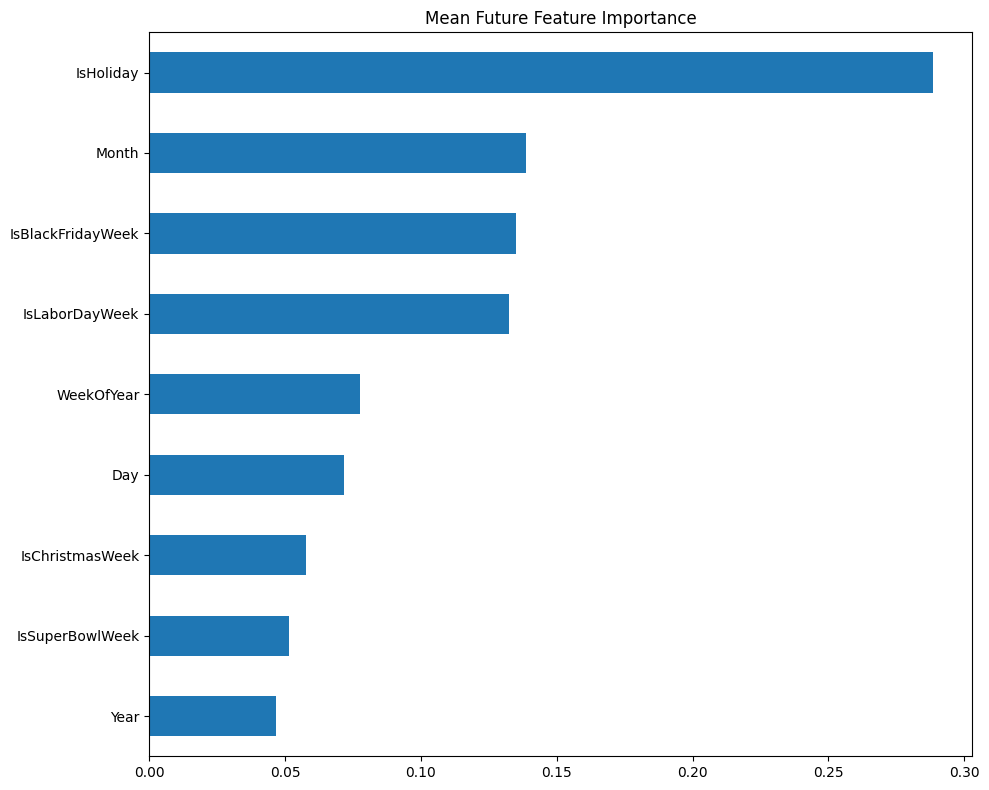

In [28]:
print("\n--- Generating Interpretability Plots ---")

print("Plotting mean attention weights...")
attention_fig = plot_attention(nf.models[0])
if attention_fig:
    wandb.log({"Attention Weights": wandb.Image(attention_fig)})

print("Calculating and plotting feature importances...")
try:
    feature_importances = nf.models[0].feature_importances()
    static_fi = feature_importances['Static covariates']
    fig_static, ax_static = plt.subplots(figsize=(10, 5))
    static_fi.plot(kind='barh', ax=ax_static, title='Static Feature Importance', legend=False)
    plt.tight_layout()
    wandb.log({"Static Feature Importance": wandb.Image(fig_static)})
    plt.show()

    hist_fi = feature_importances['Past variable importance over time'].mean().sort_values()
    fig_hist, ax_hist = plt.subplots(figsize=(10, 8))
    hist_fi.plot(kind='barh', ax=ax_hist, title='Mean Historic Feature Importance', legend=False)
    plt.tight_layout()
    wandb.log({"Historic Feature Importance": wandb.Image(fig_hist)})
    plt.show()

    # Plot future feature importance
    # The features are columns. We take the mean importance across time to get a single score.
    futr_fi = feature_importances['Future variable importance over time'].mean().sort_values()
    fig_futr, ax_futr = plt.subplots(figsize=(10, 8))
    futr_fi.plot(kind='barh', ax=ax_futr, title='Mean Future Feature Importance', legend=False)
    plt.tight_layout()
    wandb.log({"Future Feature Importance": wandb.Image(fig_futr)})
    plt.show()

except Exception as e:
    print(f"Could not generate feature importance plots: {e}")


In [30]:
print("\n--- Generating final submission file ---")

print("Retraining model on full dataset for maximum accuracy...")
full_train_df = pd.concat([train_df, validation_df])
nf_full_train_df = prepare_for_nf(full_train_df)

full_static_df = nf_full_train_df[['unique_id'] + stat_exog_list].drop_duplicates()
nf_full_train_df_time_varying = nf_full_train_df[time_varying_cols]

wandb_logger = WandbLogger(
        project=WANDB_PROJECT,
        name=f"final-first-model",
        reinit=True,
        log_model=False)

final_models = [
    TFT(
        h=HORIZON,
        input_size=INPUT_SIZE,
        stat_exog_list=stat_exog_list,
        hist_exog_list=hist_exog_list,
        futr_exog_list=futr_exog_list,
        hidden_size=64,
        n_head=4,
        max_steps=2000,
        loss=MAE(),
        scaler_type='robust',
        random_seed=42,
        logger=wandb_logger
    )
]
nf_final = NeuralForecast(models=final_models, freq='W-FRI')
nf_final.fit(df=nf_full_train_df_time_varying, static_df=full_static_df)
print("Final model retrained.")



--- Generating final submission file ---
Retraining model on full dataset for maximum accuracy...


wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.
INFO:lightning_fabric.utilities.seed:Seed set to 42
wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.
wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: Th

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.


Final model retrained.


In [31]:

print("Preparing test data and making final predictions...")
nf_test_df = prepare_for_nf(test_df, is_train=False)

# Apply the same robust prediction logic for the final submission
final_future_scaffold = nf_final.make_future_dataframe()
final_future_with_features = pd.merge(final_future_scaffold, nf_test_df, on=['unique_id', 'ds'], how='left')
final_future_with_features.fillna(method='ffill', inplace=True)
final_future_with_features.fillna(method='bfill', inplace=True)
final_future_with_features.fillna(0, inplace=True)

final_predictions_df = nf_final.predict(futr_df=final_future_with_features, static_df=full_static_df)



Preparing test data and making final predictions...


/tmp/ipython-input-650758521.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_future_with_features.fillna(method='ffill', inplace=True)
/tmp/ipython-input-650758521.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_future_with_features.fillna(method='ffill', inplace=True)
/tmp/ipython-input-650758521.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_future_with_features.fillna(method='bfill', inplace=True)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU c

Predicting: |          | 0/? [00:00<?, ?it/s]

In [32]:
print("Formatting submission file...")
# Create the required 'Id' column in the original test_df
test_df['Id'] = test_df['Store'].astype(str) + '_' + test_df['Dept'].astype(str) + '_' + test_df['Date'].dt.strftime('%Y-%m-%d')

# Merge predictions back to the original test_df structure to ensure correctness
final_predictions_df.rename(columns={'ds': 'Date', 'TFT': 'Weekly_Sales'}, inplace=True)
final_predictions_df['Date'] = pd.to_datetime(final_predictions_df['Date'])
final_predictions_df['unique_id'] = final_predictions_df['unique_id'].astype(str)
final_predictions_df['Store'] = final_predictions_df['unique_id'].apply(lambda x: int(x.split('_')[0]))
final_predictions_df['Dept'] = final_predictions_df['unique_id'].apply(lambda x: int(x.split('_')[1]))

# Use a robust mapping to create the final submission file
prediction_map = final_predictions_df.set_index(['Store', 'Dept', 'Date'])['Weekly_Sales'].to_dict()
test_df['key'] = list(zip(test_df['Store'], test_df['Dept'], test_df['Date']))
test_df['Weekly_Sales'] = test_df['key'].map(prediction_map)

final_submission = test_df[['Id', 'Weekly_Sales']].copy()
final_submission['Weekly_Sales'] = final_submission['Weekly_Sales'].clip(lower=0).fillna(0)
final_submission.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created successfully.")


Formatting submission file...

Submission file 'submission.csv' created successfully.


In [33]:
print("Logging submission file as a W&B Artifact...")
artifact = wandb.Artifact('submission-file', type='submission')
artifact.add_file('submission.csv')
wandb.log_artifact(artifact)

wandb.finish()
print("\nExperiment complete. Check your W&B dashboard for all results and plots.")

Logging submission file as a W&B Artifact...


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
train_loss_epoch,▇██▇▇▇▆▄▇█▅▇▄▆▅▆▅▄▄▁
train_loss_step,▁█▁▁▁▂▁▁▁▁▇▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▇▂▁▁▁▁▁▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
validation_mae,▁
validation_rmse,▁
validation_wmae,▁
epoch,19
train_loss_epoch,1.35969
train_loss_step,1.37808
trainer/global_step,1999



Experiment complete. Check your W&B dashboard for all results and plots.


Above model has an overfit, so below will try to improve that


In [11]:
print("\n--- Performing Feature Selection ---")

# All static features were important, so we keep them all.
stat_exog_list = ['Store', 'Dept', 'Size'] + [col for col in train_df.columns if 'Type_' in col]

# We select the top ~10 most important historic features.
hist_exog_list = [
    'CPI', 'Sales_Roll_Mean_4', 'IsBlackFridayWeek', 'Fuel_Price', 'Day',
    'Sales_Lag_4', 'IsSuperBowlWeek', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_13'
]

# We select the top ~8 most important future features.
futr_exog_list = [
    'IsHoliday', 'Month', 'IsBlackFridayWeek', 'IsLaborDayWeek',
    'WeekOfYear', 'Day', 'IsChristmasWeek', 'IsSuperBowlWeek'
]
print("Feature selection complete")


--- Performing Feature Selection ---
Feature selection complete


In [16]:
from pytorch_lightning.loggers import WandbLogger

In [21]:
!pip install hyperopt -q

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [12]:
def prepare_for_nf(df, is_train=True):
    df_copy = df.copy()
    df_copy['unique_id'] = df_copy['Store'].astype(str) + '_' + df_copy['Dept'].astype(str)
    df_copy.rename(columns={'Date': 'ds'}, inplace=True)
    if is_train and 'Weekly_Sales' in df_copy.columns:
        df_copy.rename(columns={'Weekly_Sales': 'y'}, inplace=True)
    return df_copy

nf_train_df = prepare_for_nf(train_df)
nf_validation_df = prepare_for_nf(validation_df)

static_df = nf_train_df[['unique_id'] + stat_exog_list].drop_duplicates().reset_index(drop=True)
time_varying_cols = ['unique_id', 'ds', 'y'] + hist_exog_list + futr_exog_list
nf_train_df_time_varying = nf_train_df[time_varying_cols]

In [22]:
space = {
    'hidden_size': hp.choice('hidden_size', [16, 32, 64]),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'dropout': hp.uniform('dropout', 0.1, 0.3),
    'attention_dropout': hp.uniform('attention_dropout', 0.1, 0.3),
    'n_head': hp.choice('n_head', [2, 4]),
}

In [25]:
def objective(params):
    gc.collect()
    torch.cuda.empty_cache()

    # The 'params' dictionary now holds the hyperparameters for the trial
    print(f"\n---> Testing params: {params}")

    # The WandB integration can remain the same
    run_name = f"trial_hs-{params['hidden_size']}_lr-{params['learning_rate']:.5f}"
    wandb_logger = WandbLogger(
        project=WANDB_PROJECT, name=run_name, group="TFT-Hyperopt",
        config=params, reinit=True, log_model=False
    )

    model = TFT(
        h=HORIZON, input_size=INPUT_SIZE, stat_exog_list=stat_exog_list,
        hist_exog_list=hist_exog_list, futr_exog_list=futr_exog_list,
        batch_size=64, max_steps=1000, early_stop_patience_steps=10,
        loss=MAE(), scaler_type='robust', random_seed=42, logger=wandb_logger,
        **params  # Unpack the hyperparameter dictionary here
    )

    nf = NeuralForecast(models=[model], freq='W-FRI')
    nf.fit(df=nf_train_df_time_varying, static_df=static_df, val_size=HORIZON)

    # Evaluation
    future_scaffold = nf.make_future_dataframe()
    future_with_features = pd.merge(future_scaffold, nf_validation_df, on=['unique_id', 'ds'], how='left')
    future_with_features.fillna(method='ffill', inplace=True)
    future_with_features.fillna(method='bfill', inplace=True)
    future_with_features.fillna(0, inplace=True)
    predictions_df = nf.predict(futr_df=future_with_features, static_df=static_df)
    eval_df = pd.merge(nf_validation_df, predictions_df, on=['unique_id', 'ds'])

    score = wmae(eval_df['y'], eval_df['TFT'], eval_df['IsHoliday'])
    wandb_logger.experiment.log({"validation_wmae": score})
    wandb_logger.experiment.finish()

    # 3. Hyperopt requires a dictionary return
    return {'loss': score, 'status': STATUS_OK}


In [28]:
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=15, # Same as n_trials
    trials=trials
)


---> Testing params: {'attention_dropout': 0.14655977082027044, 'dropout': 0.2700900205479516, 'hidden_size': 32, 'learning_rate': 0.005911061166873404, 'n_head': 2}
  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]

wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.

INFO:lightning_fabric.utilities.seed:Seed set to 42
wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.

wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

ERROR:hyperopt.fmin:job exception: 'DataFrame' object has no attribute 'is_nan'


  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]


AttributeError: 'DataFrame' object has no attribute 'is_nan'

In [27]:
def wmae(y_true, y_pred, is_holiday):
    """Computes the Weighted Mean Absolute Error in a robust way."""
    y_true, y_pred, is_holiday = np.array(y_true), np.array(y_pred), np.array(is_holiday)
    weights = 1 + 4 * is_holiday.astype(int)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)


In [20]:
# Create a study and run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15) # Run 15 different trials


[I 2025-07-31 22:13:12,336] A new study created in memory with name: no-name-1e87ff86-14c4-4de2-847d-1e62d5866a6c
wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


INFO:lightning_fabric.utilities.seed:Seed set to 42
wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.
wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
[W 2025-07-31 22:13:15,105] Trial 0 failed with parameters: {'hidden_size': 64, 'learning_rate': 0.007596173622378361, 'dropout': 0.10020428061918962, 'attention_dropout': 0.12911786699798217, 'n_head': 2} because of the following error: AttributeError("'DataFrame' object has no attribute 'is_nan'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^

AttributeError: 'DataFrame' object has no attribute 'is_nan'

In [ ]:
best_params = study.best_params
best_wmae = study.best_value
print(f"\n--- Tuning Complete ---")
print(f"Best WMAE found: {best_wmae:.4f}")
print(f"Best hyperparameters: {best_params}")

In [ ]:
run = wandb.init(project=WANDB_PROJECT, name="TFT-Final-Tuned-Model", reinit=True)
run.config.update(best_params)
run.config.update({"final_validation_wmae": best_wmae})